In [4]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
fg = pd.read_csv('../data/fear_greed_index.csv') 
trades = pd.read_csv('../data/historical_data.csv') 

print("Loaded files.")
print("FG cols:", fg.columns.tolist())
print("Trades cols:", trades.columns.tolist())


Loaded files.
FG cols: ['timestamp', 'value', 'classification', 'date']
Trades cols: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']


In [50]:
fg['date'] = pd.to_datetime(fg['date'], errors='coerce').dt.date
fg.rename(columns={'classification':'sentiment', 'value':'fg_value'}, inplace=True)

time_col = 'Timestamp IST' if 'Timestamp IST' in trades.columns else 'Timestamp'
trades['time_raw'] = trades[time_col]

trades['time'] = pd.to_datetime(trades['time_raw'], errors='coerce')
if trades['time'].isna().mean() > 0.4:
    trades['time'] = pd.to_datetime(trades['time_raw'], unit='ms', errors='coerce')

trades['date'] = trades['time'].dt.date

print("Parsed times. Null times:", trades['time'].isna().sum())
display(trades[['time_raw','time','date']].head())

Parsed times. Null times: 211224


,time_raw,time,date
0,02-12-2024 22:50,NaT,NaT
1,02-12-2024 22:50,NaT,NaT
2,02-12-2024 22:50,NaT,NaT
3,02-12-2024 22:50,NaT,NaT
4,02-12-2024 22:50,NaT,NaT


In [6]:
trades = trades.rename(columns={
    'Account':'account',
    'Coin':'symbol',
    'Execution Price':'execution_price',
    'Size Tokens':'size_tokens',
    'Size USD':'size_usd',
    'Side':'side',
    'Start Position':'start_position',
    'Direction':'direction',
    'Closed PnL':'closedPnL',
    'Fee':'fee'
})

# numeric cast
for c in ['closedPnL','size_usd','execution_price','size_tokens','fee','start_position']:
    if c in trades.columns:
        trades[c] = pd.to_numeric(trades[c], errors='coerce')

print("Numeric casts done.")
print("closedPnL NaNs:", trades['closedPnL'].isna().sum() if 'closedPnL' in trades.columns else 'no closedPnL col')

Numeric casts done.
closedPnL NaNs: 0


In [7]:
# drop incomplete trades
before = len(trades)
trades = trades[trades['closedPnL'].notna()].copy()
after = len(trades)
print(f"Dropped {before-after} rows with missing closedPnL. Remaining trades: {after}")

# quick head
display(trades.head())

Dropped 0 rows with missing closedPnL. Remaining trades: 211224


,account,symbol,execution_price,size_tokens,size_usd,side,Timestamp IST,start_position,direction,closedPnL,Transaction Hash,Order ID,Crossed,fee,Trade ID,Timestamp,time_raw,time,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,02-12-2024 22:50,NaT,NaT
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,02-12-2024 22:50,NaT,NaT
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,02-12-2024 22:50,NaT,NaT
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,02-12-2024 22:50,NaT,NaT
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,02-12-2024 22:50,NaT,NaT


In [9]:
# Ensure fg['date'] is datetime64[ns] (midnight)
fg['date'] = pd.to_datetime(fg['date'], errors='coerce')
fg['date'] = fg['date'].dt.normalize()   # sets time to 00:00:00

# Ensure trades['date'] is datetime64[ns]
# If trades['date'] already exists and might be python.date, coerce via to_datetime
trades['date'] = pd.to_datetime(trades['date'], errors='coerce')
trades['date'] = trades['date'].dt.normalize()

# Show dtypes so you can confirm
print("fg['date'] dtype:", fg['date'].dtype)
print("trades['date'] dtype:", trades['date'].dtype)


fg['date'] dtype: datetime64[ns]
trades['date'] dtype: datetime64[ns]


In [10]:
merged = trades.merge(fg[['date','sentiment','fg_value']], on='date', how='left')
print("Merged. Null sentiment count:", merged['sentiment'].isna().sum(), "of", len(merged))

Merged. Null sentiment count: 211224 of 211224


In [11]:
# create a UTC-shifted date (subtract 5.5 hours if trades are in IST and FG in UTC)
trades['time'] = pd.to_datetime(trades['time'], errors='coerce')  # ensure time is datetime
trades['date_utc'] = (trades['time'] - pd.Timedelta(hours=5, minutes=30)).dt.normalize()

# show example
display(trades[['time','date','date_utc']].head())

# merge using date_utc -> fg['date']
merged_shift = trades.merge(fg[['date','sentiment','fg_value']], left_on='date_utc', right_on='date', how='left')

print("Merged_shift. Null sentiment count:", merged_shift['sentiment'].isna().sum(), "of", len(merged_shift))


,time,date,date_utc
0,NaT,NaT,NaT
1,NaT,NaT,NaT
2,NaT,NaT,NaT
3,NaT,NaT,NaT
4,NaT,NaT,NaT


Merged_shift. Null sentiment count: 211224 of 211224


In [12]:
print("fg date example:", fg['date'].dropna().head().tolist())
print("trades date example:", trades['date'].dropna().head().tolist())
print("Any nulls in fg['date']?", fg['date'].isna().sum())
print("Any nulls in trades['date']?", trades['date'].isna().sum())

fg date example: [Timestamp('2018-02-01 00:00:00'), Timestamp('2018-02-03 00:00:00'), Timestamp('2018-02-07 00:00:00'), Timestamp('2018-02-08 00:00:00'), Timestamp('2018-02-09 00:00:00')]
trades date example: []
Any nulls in fg['date']? 0
Any nulls in trades['date']? 211224


In [17]:
# show which raw time column we used
print("time_raw column head:")
display(trades['time_raw'].head(30))

# show unique sample values (first 100 uniques)
print("\nUnique samples (up to 100):")
display(trades['time_raw'].dropna().astype(str).unique()[:100])

# show dtype and a quick value_count of non-null
print("\nDtype:", trades['time_raw'].dtype)
print("Non-null count:", trades['time_raw'].notna().sum())

time_raw column head:


0     02-12-2024 22:50
1     02-12-2024 22:50
2     02-12-2024 22:50
3     02-12-2024 22:50
4     02-12-2024 22:50
5     02-12-2024 22:50
6     02-12-2024 22:50
7     02-12-2024 22:50
8     02-12-2024 22:50
9     02-12-2024 22:50
10    02-12-2024 22:50
11    02-12-2024 22:51
12    02-12-2024 22:51
13    02-12-2024 22:51
14    02-12-2024 22:51
15    02-12-2024 22:54
16    02-12-2024 22:54
17    02-12-2024 22:54
18    02-12-2024 22:54
19    02-12-2024 22:54
20    02-12-2024 22:54
21    02-12-2024 22:54
22    02-12-2024 22:54
23    02-12-2024 22:54
24    02-12-2024 22:54
25    02-12-2024 22:54
26    02-12-2024 22:54
27    02-12-2024 22:54
28    02-12-2024 22:54
29    02-12-2024 22:54
Name: time_raw, dtype: object


Unique samples (up to 100):


array(['02-12-2024 22:50', '02-12-2024 22:51', '02-12-2024 22:54',
       '02-12-2024 23:13', '02-12-2024 23:21', '03-12-2024 14:39',
       '03-12-2024 14:42', '03-12-2024 14:44', '03-12-2024 15:22',
       '03-12-2024 19:38', '03-12-2024 20:56', '03-12-2024 23:37',
       '03-12-2024 23:38', '04-12-2024 05:30', '04-03-2025 23:23',
       '04-03-2025 23:27', '05-03-2025 12:42', '11-03-2025 13:34',
       '18-03-2025 12:50', '18-03-2025 22:25', '08-04-2025 20:50',
       '08-04-2025 22:27', '09-04-2025 12:49', '09-04-2025 23:21',
       '10-04-2025 01:55', '12-04-2025 15:51', '12-04-2025 20:07',
       '21-04-2025 12:57', '23-04-2025 19:20', '24-04-2025 20:04',
       '24-04-2025 22:40', '24-04-2025 23:01', '25-04-2025 10:52',
       '25-04-2025 13:39', '20-09-2024 14:06', '20-09-2024 18:09',
       '24-09-2024 17:27', '25-09-2024 19:42', '25-09-2024 19:43',
       '25-09-2024 19:45', '26-09-2024 18:57', '26-09-2024 19:05',
       '26-09-2024 19:22', '26-09-2024 19:26', '26-09-2024 19:


Dtype: object
Non-null count: 211224


In [24]:
# make sure fg['date'] is normalized datetime64[ns]
fg['date'] = pd.to_datetime(fg['date'], errors='coerce').dt.normalize()
# trades['date'] already normalized in previous step
trades['date'] = pd.to_datetime(trades['date'], errors='coerce').dt.normalize()

# direct merge (no shift) — quick check
merged_direct = trades.merge(fg[['date','sentiment','fg_value']], on='date', how='left')
direct_missing = merged_direct['sentiment'].isna().sum()

# shifted merge (trades date shifted to UTC) — you computed merged_shift earlier; recompute to be safe
trades['date_utc'] = (trades['time'] - pd.Timedelta(hours=5, minutes=30)).dt.normalize()
merged_shift = trades.merge(fg[['date','sentiment','fg_value']], left_on='date_utc', right_on='date', how='left')
shift_missing = merged_shift['sentiment'].isna().sum()

print("Total trades:", len(trades))
print("Direct-merge missing sentiment:", direct_missing, f"({direct_missing/len(trades):.1%})")
print("Shift-merge missing sentiment:", shift_missing, f"({shift_missing/len(trades):.1%})")

# how many unique trade dates overlap with FG
trade_dates = set(trades['date'].dropna().unique())
fg_dates = set(fg['date'].dropna().unique())
overlap_dates = len(trade_dates & fg_dates)
print("Unique trade dates:", len(trade_dates))
print("Unique FG dates:", len(fg_dates))
print("Overlap unique dates:", overlap_dates)

Total trades: 211224
Direct-merge missing sentiment: 99084 (46.9%)
Shift-merge missing sentiment: 101046 (47.8%)
Unique trade dates: 480
Unique FG dates: 1414
Overlap unique dates: 284


In [25]:
# Use direct sentiment if available, otherwise fallback to shifted sentiment
# First get direct and shifted sentiment columns into a single DF
tmp_direct = merged_direct[['account','symbol','time','date','closedPnL','size_usd','side']].copy()
tmp_direct['sentiment_direct'] = merged_direct['sentiment'].values
tmp_shift = merged_shift[['sentiment']].copy()
tmp_shift = tmp_shift.rename(columns={'sentiment':'sentiment_shift'})

# align indices (both merges maintain original trades index if we merged from trades)
merged_final = tmp_direct.copy()
merged_final['sentiment_shift'] = tmp_shift['sentiment_shift'].values

# pick sentiment: direct if exists else shifted else Unknown
merged_final['sentiment'] = merged_final['sentiment_direct'].fillna(merged_final['sentiment_shift'])
merged_final['sentiment'] = merged_final['sentiment'].fillna('Unknown')

# bring back other useful columns from trades (size, Closed PnL, time etc.)
# If you need more columns, re-attach them from trades by index
cols_from_trades = ['account','symbol','time','date','size_usd','closedPnL','side','start_position','direction','fee','time_raw','date_utc']
for c in cols_from_trades:
    if c in trades.columns:
        merged_final[c] = trades[c].values

print("Final merged shape:", merged_final.shape)
print("Sentiment distribution (final):")
print(merged_final['sentiment'].value_counts(dropna=False))

Final merged shape: (211224, 15)
Sentiment distribution (final):
sentiment
Unknown    90031
Fear       67387
Greed      53806
Name: count, dtype: int64


In [26]:
# numeric casts & basic features
merged_final['closedPnL'] = pd.to_numeric(merged_final['closedPnL'], errors='coerce')
merged_final['size_usd'] = pd.to_numeric(merged_final['size_usd'], errors='coerce').fillna(0)
merged_final['isProfit'] = merged_final['closedPnL'] > 0
merged_final['absPnL'] = merged_final['closedPnL'].abs()
merged_final['risk_score'] = merged_final['size_usd']  # proxy
merged_final['side'] = merged_final['side'].astype(str).str.lower()
merged_final['isLong'] = merged_final['side'].apply(lambda x: 1 if ('buy' in x) or ('long' in x) else 0)
merged_final['hour'] = pd.to_datetime(merged_final['time'], errors='coerce').dt.hour

# conservative outlier trim (0.5 - 99.5 percentile) but applied only to rows WITH closedPnL
mask_has_pnl = merged_final['closedPnL'].notna()
low = merged_final.loc[mask_has_pnl,'closedPnL'].quantile(0.005)
high = merged_final.loc[mask_has_pnl,'closedPnL'].quantile(0.995)
merged_clean = merged_final[ (merged_final['closedPnL'].between(low, high)) | (merged_final['closedPnL'].isna()) ].copy()

print("Rows total:", len(merged_final))
print("Rows after trimming (merged_clean):", len(merged_clean))
print("Sentiment counts in trimmed DF:")
print(merged_clean['sentiment'].value_counts(dropna=False))

Rows total: 211224
Rows after trimming (merged_clean): 209110
Sentiment counts in trimmed DF:
sentiment
Unknown    89097
Fear       66788
Greed      53225
Name: count, dtype: int64


In [36]:
# counts
print("Total rows (merged_clean):", len(merged_clean))
print("Sentiment distribution:")
print(merged_clean['sentiment'].value_counts().head(10))

# group stats by sentiment (excluding Unknown)
stats = merged_clean[merged_clean['sentiment']!='Unknown'].groupby('sentiment').agg(
    trades_count=('closedPnL','count'),
    win_rate=('isProfit','mean'),
    avg_pnl=('closedPnL','mean'),
    median_pnl=('closedPnL','median'),
    avg_size=('size_usd','mean')
)
display(stats.round(4))

Total rows (merged_clean): 209110
Sentiment distribution:
sentiment
Unknown    89097
Fear       66788
Greed      53225
Name: count, dtype: int64


,trades_count,win_rate,avg_pnl,median_pnl,avg_size
sentiment,,,,,
Fear,66788,0.4201,28.1055,0.0,6750.5334
Greed,53225,0.3842,27.4312,0.0,5215.7162


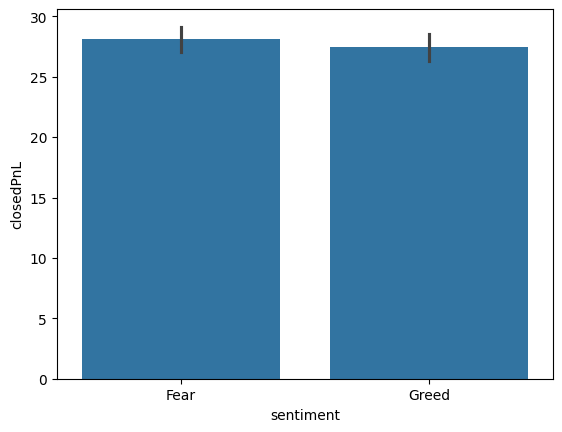

In [37]:
sns.barplot(data=df_sentiment, x='sentiment', y='closedPnL', estimator='mean')
plt.show()

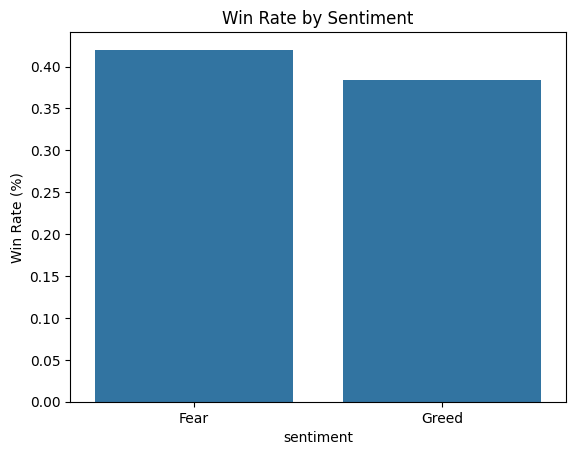

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

df_sentiment = merged_clean[merged_clean['sentiment'].isin(['Fear','Greed'])]

winrate_plot = df_sentiment.groupby('sentiment')['isProfit'].mean().reset_index()

sns.barplot(data=winrate_plot, x='sentiment', y='isProfit')
plt.title("Win Rate by Sentiment")
plt.ylabel("Win Rate (%)")
plt.show()

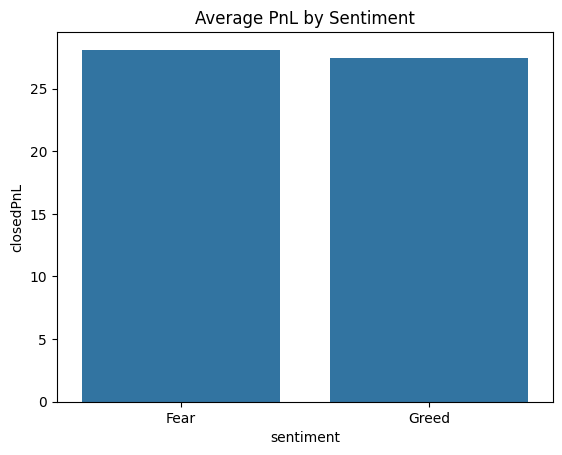

In [33]:
pnl_plot = df_sentiment.groupby('sentiment')['closedPnL'].mean().reset_index()

sns.barplot(data=pnl_plot, x='sentiment', y='closedPnL')
plt.title("Average PnL by Sentiment")
plt.show()

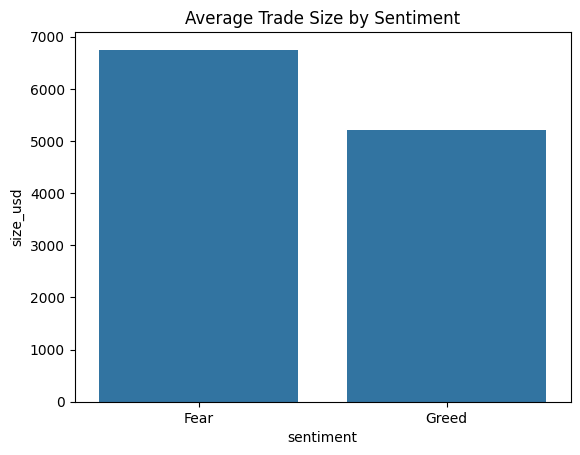

In [34]:
size_plot = df_sentiment.groupby('sentiment')['size_usd'].mean().reset_index()

sns.barplot(data=size_plot, x='sentiment', y='size_usd')
plt.title("Average Trade Size by Sentiment")
plt.show()

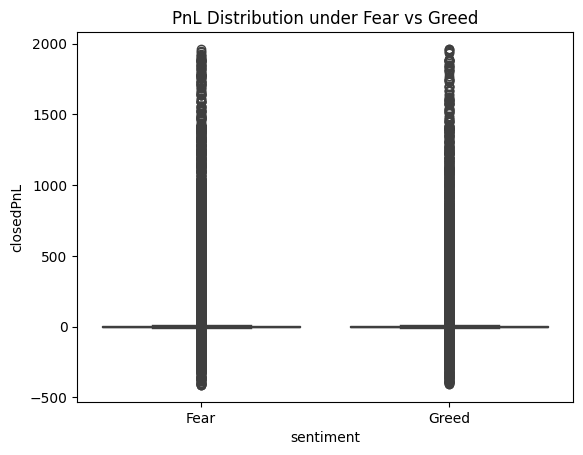

In [35]:
sns.boxplot(data=df_sentiment, x='sentiment', y='closedPnL')
plt.title("PnL Distribution under Fear vs Greed")
plt.show()

In [38]:
# quick guard — adapt if you named differently
try:
    merged_clean
except NameError:
    raise NameError("merged_clean not found. Re-run Hour 2 cleaning cells first.")

df_sentiment = merged_clean[merged_clean['sentiment'].isin(['Fear','Greed'])].copy()
print("Rows with sentiment:", len(df_sentiment))

Rows with sentiment: 120013


In [39]:
acct_stats = df_sentiment.groupby('account').agg(
    trades_count=('closedPnL','count'),
    total_pnl=('closedPnL','sum'),
    avg_pnl=('closedPnL','mean'),
    win_rate=('isProfit','mean'),
    avg_size=('size_usd','mean')
).reset_index()

top_by_total = acct_stats.sort_values('total_pnl', ascending=False).head(15)
top_by_trades = acct_stats.sort_values('trades_count', ascending=False).head(15)
top_by_win = acct_stats[acct_stats['trades_count']>=50].sort_values('win_rate', ascending=False).head(15)  # filter tiny accounts

display(top_by_total)
display(top_by_trades)
display(top_by_win)

,account,trades_count,total_pnl,avg_pnl,win_rate,avg_size
29,0xbaaaf6571ab7d571043ff1e313a9609a10637864,13290,467185.223060,35.153139,0.512265,3126.958104
31,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,21074,347929.463874,16.509892,0.407327,1732.870207
13,0x513b8629fe877bb581bf244e326a047b249c4ff1,9633,339164.466976,35.208602,0.370601,32498.331524
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2312,279309.836512,120.808753,0.406574,12191.997638
27,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,10112,249658.219878,24.689302,0.281349,4226.851750
12,0x4f93fead39b70a1824f981a54d4e55b278e9f760,3855,216594.098339,56.185240,0.350973,14954.451362
19,0x8170715b3b381dffb7062c0298972d4727a0a63b,3379,157964.942775,46.749021,0.414324,1679.203075
11,0x4acb90e786d897ecffb614dc822eb231b4ffb9f4,2892,156382.280784,54.074094,0.477178,7400.684288
17,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,4731,154542.575931,32.665943,0.808920,2234.457518
30,0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3,1624,151956.525787,93.569289,0.405172,6574.742143


,account,trades_count,total_pnl,avg_pnl,win_rate,avg_size
31,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,21074,347929.463874,16.509892,0.407327,1732.870207
29,0xbaaaf6571ab7d571043ff1e313a9609a10637864,13290,467185.223060,35.153139,0.512265,3126.958104
27,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,10112,249658.219878,24.689302,0.281349,4226.851750
13,0x513b8629fe877bb581bf244e326a047b249c4ff1,9633,339164.466976,35.208602,0.370601,32498.331524
21,0x8477e447846c758f5a675856001ea72298fd9cb5,8839,11.645077,0.001317,0.232605,683.739168
23,0xa0feb3725a9335f49874d7cd8eaad6be45b27416,7682,48070.497693,6.257550,0.332335,1221.527741
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,5587,37566.797208,6.723966,0.440308,1601.336479
10,0x47add9a56df66b524d5e2c1993a43cde53b6ed85,4747,58373.225720,12.296867,0.356436,515.364750
17,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,4731,154542.575931,32.665943,0.808920,2234.457518
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,4646,48368.906909,10.410871,0.436505,544.819858


,account,trades_count,total_pnl,avg_pnl,win_rate,avg_size
17,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,4731,154542.575931,32.665943,0.808920,2234.457518
5,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,353,2546.152328,7.212896,0.702550,1110.940368
24,0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0,242,22984.014369,94.975266,0.619835,1182.280868
7,0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6,104,4809.227982,46.242577,0.586538,4209.973365
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,763,19967.869295,26.170209,0.549148,3111.627969
29,0xbaaaf6571ab7d571043ff1e313a9609a10637864,13290,467185.223060,35.153139,0.512265,3126.958104
28,0xb899e522b5715391ae1d4f137653e7906c5e2115,3204,66139.977090,20.642939,0.510612,22133.602640
9,0x430f09841d65beb3f27765503d0f850b8bce7713,983,119436.771147,121.502310,0.498474,1426.495951
11,0x4acb90e786d897ecffb614dc822eb231b4ffb9f4,2892,156382.280784,54.074094,0.477178,7400.684288
18,0x7f4f299f74eec87806a830e3caa9afa5f2b9db8f,646,10720.034307,16.594480,0.470588,3940.111966


In [40]:
acct_sent = df_sentiment.groupby(['account','sentiment']).agg(
    trades_count=('closedPnL','count'),
    avg_pnl=('closedPnL','mean'),
    win_rate=('isProfit','mean')
).reset_index()

# pivot so we can compute deltas
pivot = acct_sent.pivot(index='account', columns='sentiment', values=['avg_pnl','win_rate','trades_count'])
# flatten
pivot.columns = ['_'.join(col).strip() for col in pivot.columns.values]
pivot = pivot.reset_index().fillna(0)

# compute deltas: Fear - Greed
pivot['avg_pnl_delta_Fear_minus_Greed'] = pivot.get('avg_pnl_Fear',0) - pivot.get('avg_pnl_Greed',0)
pivot['win_rate_delta_Fear_minus_Greed'] = pivot.get('win_rate_Fear',0) - pivot.get('win_rate_Greed',0)

# find accounts that perform much better in Fear vs Greed
better_in_fear = pivot.sort_values('avg_pnl_delta_Fear_minus_Greed', ascending=False).head(15)
better_in_greed = pivot.sort_values('avg_pnl_delta_Fear_minus_Greed').head(15)

display(better_in_fear[['account','avg_pnl_Fear','avg_pnl_Greed','avg_pnl_delta_Fear_minus_Greed','win_rate_Fear','win_rate_Greed','trades_count_Fear','trades_count_Greed']])
display(better_in_greed[['account','avg_pnl_Fear','avg_pnl_Greed','avg_pnl_delta_Fear_minus_Greed','win_rate_Fear','win_rate_Greed','trades_count_Fear','trades_count_Greed']])

,account,avg_pnl_Fear,avg_pnl_Greed,avg_pnl_delta_Fear_minus_Greed,win_rate_Fear,win_rate_Greed,trades_count_Fear,trades_count_Greed
8,0x420ab45e0bd8863569a5efbb9c05d91f40624641,198.161697,0.000000,198.161697,0.315217,0.000000,92.0,96.0
16,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,196.744845,7.591840,189.153005,0.652068,0.122951,411.0,488.0
0,0x083384f897ee0f19899168e3b1bec365f52a9012,146.743452,57.648320,89.095132,0.495424,0.190193,1639.0,673.0
30,0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3,119.122007,30.071335,89.050672,0.496546,0.178112,1158.0,466.0
29,0xbaaaf6571ab7d571043ff1e313a9609a10637864,35.168525,1.088796,34.079729,0.512346,0.333333,13284.0,6.0
12,0x4f93fead39b70a1824f981a54d4e55b278e9f760,78.879654,44.996243,33.883411,0.384918,0.334237,1273.0,2582.0
7,0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6,53.880498,22.106747,31.773751,0.620253,0.480000,79.0,25.0
28,0xb899e522b5715391ae1d4f137653e7906c5e2115,20.642939,0.000000,20.642939,0.510612,0.000000,3204.0,0.0
5,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,11.222697,-2.931900,14.154597,0.687747,0.740000,253.0,100.0
19,0x8170715b3b381dffb7062c0298972d4727a0a63b,52.180354,40.453534,11.726819,0.274531,0.576358,1814.0,1565.0


,account,avg_pnl_Fear,avg_pnl_Greed,avg_pnl_delta_Fear_minus_Greed,win_rate_Fear,win_rate_Greed,trades_count_Fear,trades_count_Greed
6,0x39cef799f8b69da1995852eea189df24eb5cae3c,25.778747,185.716433,-159.937686,0.326934,0.423729,1823.0,59.0
24,0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0,-26.873619,121.304422,-148.178041,0.069767,0.738693,43.0,199.0
9,0x430f09841d65beb3f27765503d0f850b8bce7713,23.692203,152.576031,-128.883828,0.101266,0.624665,237.0,746.0
14,0x6d6a4b953f202f8df5bed40692e7fd865318264a,5.544454,125.325316,-119.780862,0.214674,0.506224,368.0,241.0
15,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,-11.045027,94.959135,-106.004162,0.167224,0.251852,299.0,540.0
20,0x8381e6d82f1affd39a336e143e081ef7620a3b7f,-1.896617,94.524025,-96.420643,0.339286,0.467577,56.0,293.0
18,0x7f4f299f74eec87806a830e3caa9afa5f2b9db8f,7.006647,81.630024,-74.623377,0.461812,0.530120,563.0,83.0
25,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,47.203705,104.932417,-57.728713,0.344262,0.426829,122.0,164.0
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,12.722386,53.439405,-40.717019,0.553816,0.539683,511.0,252.0
22,0x92f17e8d81a944691c10e753af1b1baae1a2cd0d,3.686794,35.877061,-32.190267,0.073770,0.335565,244.0,1195.0


In [41]:
sym = df_sentiment.groupby(['symbol','sentiment']).agg(
    trades_count=('closedPnL','count'),
    avg_pnl=('closedPnL','mean'),
    win_rate=('isProfit','mean'),
    avg_size=('size_usd','mean')
).reset_index()

sym_pivot = sym.pivot(index='symbol', columns='sentiment', values=['trades_count','avg_pnl','win_rate','avg_size'])
sym_pivot.columns = ['_'.join(col).strip() for col in sym_pivot.columns.values]
sym_pivot = sym_pivot.fillna(0).reset_index()
# show top symbols by volume
display(sym_pivot.sort_values('trades_count_Fear', ascending=False).head(12))
display(sym_pivot.sort_values('trades_count_Greed', ascending=False).head(12))

# quick insight lines
sym_pivot['avg_pnl_delta'] = sym_pivot['avg_pnl_Fear'] - sym_pivot['avg_pnl_Greed']
display(sym_pivot.sort_values('avg_pnl_delta', ascending=False).head(10))
display(sym_pivot.sort_values('avg_pnl_delta').head(10))

,symbol,trades_count_Fear,trades_count_Greed,avg_pnl_Fear,avg_pnl_Greed,win_rate_Fear,win_rate_Greed,avg_size_Fear,avg_size_Greed
123,HYPE,30529.0,7422.0,21.552826,14.467418,0.442497,0.373619,2155.453476,1643.300656
92,BTC,10584.0,7742.0,35.117920,18.971759,0.385015,0.320718,25862.218125,20561.820682
3,@107,5531.0,8572.0,6.125077,48.325225,0.413488,0.460919,1479.427604,1768.219538
181,SOL,4356.0,1688.0,51.960117,61.743458,0.459596,0.274882,12006.074242,11835.318069
107,ETH,2805.0,3881.0,71.937598,33.362965,0.413191,0.254316,10781.346485,9558.823218
144,MELANIA,2021.0,1239.0,58.519442,56.786595,0.310737,0.684423,1608.008184,1121.207361
109,FARTCOIN,1059.0,2230.0,1.264412,22.240570,0.318225,0.396861,1126.143192,2262.638587
157,ONDO,557.0,193.0,12.159756,50.937143,0.384201,0.647668,623.000987,2978.249793
160,PAXG,522.0,0.0,-0.460709,0.000000,0.022989,0.000000,1860.495498,0.000000
132,JELLY,477.0,209.0,26.125910,62.908862,0.781971,0.889952,1811.766520,3530.856746


,symbol,trades_count_Fear,trades_count_Greed,avg_pnl_Fear,avg_pnl_Greed,win_rate_Fear,win_rate_Greed,avg_size_Fear,avg_size_Greed
3,@107,5531.0,8572.0,6.125077,48.325225,0.413488,0.460919,1479.427604,1768.219538
92,BTC,10584.0,7742.0,35.117920,18.971759,0.385015,0.320718,25862.218125,20561.820682
123,HYPE,30529.0,7422.0,21.552826,14.467418,0.442497,0.373619,2155.453476,1643.300656
107,ETH,2805.0,3881.0,71.937598,33.362965,0.413191,0.254316,10781.346485,9558.823218
109,FARTCOIN,1059.0,2230.0,1.264412,22.240570,0.318225,0.396861,1126.143192,2262.638587
181,SOL,4356.0,1688.0,51.960117,61.743458,0.459596,0.274882,12006.074242,11835.318069
144,MELANIA,2021.0,1239.0,58.519442,56.786595,0.310737,0.684423,1608.008184,1121.207361
214,ZRO,51.0,1134.0,67.271855,48.998978,0.784314,0.321869,3147.819608,556.652134
206,WLD,92.0,1084.0,15.061034,7.544195,0.380435,0.341328,1144.670978,1213.159696
168,PURR/USDC,188.0,972.0,0.235931,17.832304,0.074468,0.336420,968.035638,675.402490


,symbol,trades_count_Fear,trades_count_Greed,avg_pnl_Fear,avg_pnl_Greed,win_rate_Fear,win_rate_Greed,avg_size_Fear,avg_size_Greed,avg_pnl_delta
139,LTC,11.0,13.0,287.763325,1.744908,0.818182,0.615385,1639.332727,76.361538,286.018416
103,EIGEN,45.0,212.0,295.631911,10.724217,0.955556,0.132075,890.505778,808.286132,284.907694
190,TIA,34.0,133.0,239.323172,19.516890,0.676471,0.270677,2049.599706,3771.598872,219.806282
104,ENA,186.0,363.0,259.016698,53.993673,0.419355,0.300275,1073.906505,1771.166832,205.023025
99,DOGE,11.0,288.0,171.917664,14.201355,0.454545,0.465278,1164.419091,1308.280937,157.716309
96,COMP,9.0,0.0,148.268315,0.000000,0.444444,0.000000,1193.044444,0.000000,148.268315
182,SPX,14.0,49.0,146.943567,71.229101,0.928571,0.857143,5567.962857,4273.918163,75.714466
201,VIRTUAL,55.0,221.0,67.816772,-3.436274,0.800000,0.253394,1257.742727,419.583258,71.253046
17,@147,0.0,5.0,0.000000,-70.126539,0.000000,0.000000,0.000000,122.512000,70.126539
189,TAO,167.0,769.0,71.039588,3.234828,0.502994,0.564369,2480.326647,1439.771248,67.804760


,symbol,trades_count_Fear,trades_count_Greed,avg_pnl_Fear,avg_pnl_Greed,win_rate_Fear,win_rate_Greed,avg_size_Fear,avg_size_Greed,avg_pnl_delta
4,@109,3.0,13.0,0.000000,416.218936,0.000000,0.923077,36.203333,417.706923,-416.218936
198,USTC,0.0,2.0,0.000000,129.808683,0.000000,0.500000,0.000000,629.780000,-129.808683
84,BERA,341.0,406.0,17.785494,141.976033,0.158358,0.879310,1877.439150,1052.239384,-124.190539
65,@85,30.0,63.0,0.000000,119.649128,0.000000,0.269841,201.586000,289.343968,-119.649128
128,INJ,0.0,34.0,0.000000,97.869868,0.000000,0.735294,0.000000,4298.405882,-97.869868
133,JTO,4.0,83.0,5.619000,102.403762,0.250000,0.361446,271.160000,2333.918795,-96.784762
180,SHIA,0.0,3.0,0.000000,91.189548,0.000000,1.000000,0.000000,258.770000,-91.189548
197,UNIBOT,0.0,4.0,0.000000,81.263942,0.000000,0.500000,0.000000,583.315000,-81.263942
57,@59,14.0,22.0,0.000000,79.645275,0.000000,0.227273,430.357143,635.358182,-79.645275
112,FTM,0.0,26.0,0.000000,79.537178,0.000000,0.846154,0.000000,3804.436923,-79.537178


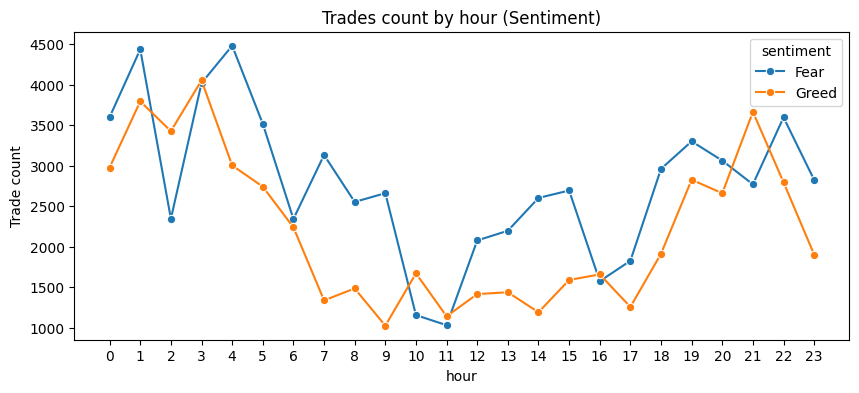

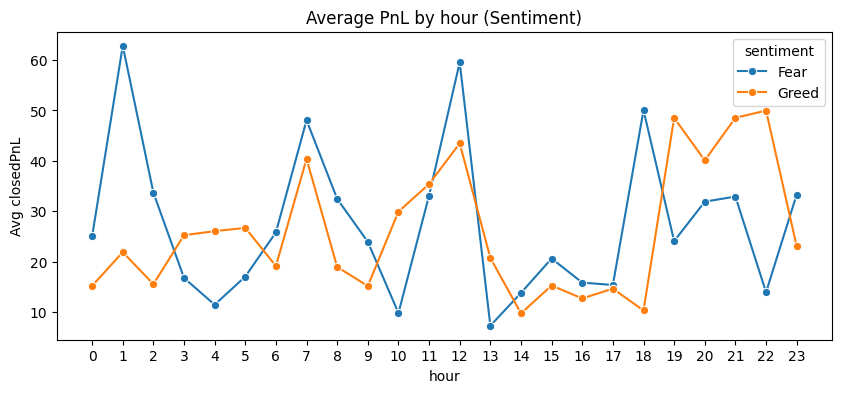

In [42]:
hour_stats = df_sentiment.groupby(['hour','sentiment']).agg(
    trades_count=('closedPnL','count'),
    avg_pnl=('closedPnL','mean'),
    win_rate=('isProfit','mean')
).reset_index()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))
sns.lineplot(data=hour_stats, x='hour', y='trades_count', hue='sentiment', marker='o')
plt.title("Trades count by hour (Sentiment)")
plt.ylabel("Trade count")
plt.xticks(range(0,24))
plt.show()

plt.figure(figsize=(10,4))
sns.lineplot(data=hour_stats, x='hour', y='avg_pnl', hue='sentiment', marker='o')
plt.title("Average PnL by hour (Sentiment)")
plt.ylabel("Avg closedPnL")
plt.xticks(range(0,24))
plt.show()

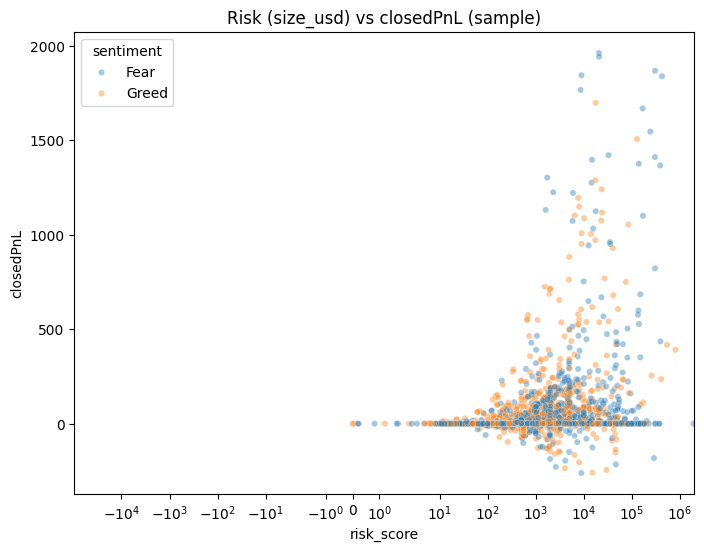

C:\Users\harsh\AppData\Local\Temp\ipykernel_4180\2389897552.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_bin = df_sentiment.groupby(['risk_q','sentiment']).agg(avg_pnl=('closedPnL','mean'), count=('closedPnL','count')).reset_index()


avg_pnl               count        
sentiment                     Fear       Greed    Fear   Greed
risk_q                                                        
(0.999, 44.72]            0.367166    0.565281  6668.0  5335.0
(44.72, 142.108]          1.679918    2.752931  5660.0  6340.0
(142.108, 275.906]        2.570522    4.154361  6281.0  5720.0
(275.906, 500.54]         5.323092   11.008091  6477.0  5533.0
(500.54, 617.0]           8.045002    2.341341  6868.0  5144.0
(617.0, 1001.662]        12.744815   21.454565  6969.0  5013.0
(1001.662, 1784.932]     18.640406   23.120800  6995.0  5006.0
(1784.932, 3214.692]     38.557589   40.438958  6943.0  5058.0
(3214.692, 10000.59]     67.902996   81.324934  6847.0  5162.0
(10000.59, 3719141.94]  114.044147  100.774487  7080.0  4914.0

In [43]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_sentiment.sample(min(5000,len(df_sentiment))), x='risk_score', y='closedPnL', hue='sentiment', alpha=0.4, s=20)
plt.xscale('symlog')  # to handle zeros and wide range
plt.title("Risk (size_usd) vs closedPnL (sample)")
plt.show()

# bin risk into quantiles and show avg pnl per bin by sentiment
df_sentiment['risk_q'] = pd.qcut(df_sentiment['risk_score'].replace(0,np.nan).fillna(0)+1, q=10, duplicates='drop')
risk_bin = df_sentiment.groupby(['risk_q','sentiment']).agg(avg_pnl=('closedPnL','mean'), count=('closedPnL','count')).reset_index()
display(risk_bin.pivot(index='risk_q', columns='sentiment', values=['avg_pnl','count']).head(12))

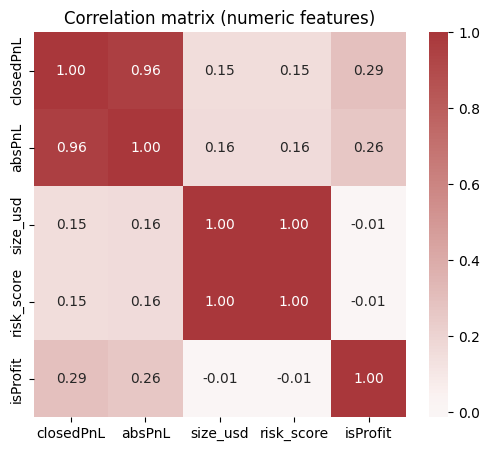

In [44]:
# choose numeric features (only rows with known sentiment)
corr_df = df_sentiment[['closedPnL','absPnL','size_usd','risk_score','isProfit']].copy().dropna()
corr = corr_df.corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag', center=0)
plt.title("Correlation matrix (numeric features)")
plt.show()

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# build account-level features (use only accounts with enough trades)
acct_features = df_sentiment.groupby('account').agg(
    trades_count=('closedPnL','count'),
    avg_pnl=('closedPnL','mean'),
    win_rate=('isProfit','mean'),
    avg_size=('size_usd','mean'),
    pnl_std=('closedPnL','std')
).reset_index().dropna()

acct_features = acct_features[acct_features['trades_count']>=20].copy()

X = acct_features[['trades_count','avg_pnl','win_rate','avg_size','pnl_std']].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
acct_features['cluster'] = kmeans.fit_predict(X_scaled)

display(acct_features.groupby('cluster').agg(
    count=('account','count'),
    avg_trades=('trades_count','mean'),
    avg_pnl=('avg_pnl','mean'),
    avg_win=('win_rate','mean'),
    avg_size=('avg_size','mean')
).round(4))

# sample accounts from each cluster
for c in acct_features['cluster'].unique():
    print("\nCluster", c, "sample accounts:")
    display(acct_features[acct_features['cluster']==c].sort_values('avg_pnl',ascending=False).head(5)[['account','trades_count','avg_pnl','win_rate','avg_size']])

,count,avg_trades,avg_pnl,avg_win,avg_size
cluster,,,,,
0,6,11771.6667,19.6366,0.3561,7248.3797
1,10,1157.7000,89.4623,0.3860,7070.9502
2,16,2362.8750,26.5293,0.4617,4605.7922



Cluster 1 sample accounts:


,account,trades_count,avg_pnl,win_rate,avg_size
9,0x430f09841d65beb3f27765503d0f850b8bce7713,983,121.502310,0.498474,1426.495951
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2312,120.808753,0.406574,12191.997638
8,0x420ab45e0bd8863569a5efbb9c05d91f40624641,188,96.972745,0.154255,6196.233617
24,0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0,242,94.975266,0.619835,1182.280868
16,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,899,94.067796,0.364850,1488.883103



Cluster 2 sample accounts:


,account,trades_count,avg_pnl,win_rate,avg_size
11,0x4acb90e786d897ecffb614dc822eb231b4ffb9f4,2892,54.074094,0.477178,7400.684288
14,0x6d6a4b953f202f8df5bed40692e7fd865318264a,609,52.945419,0.330049,724.210049
19,0x8170715b3b381dffb7062c0298972d4727a0a63b,3379,46.749021,0.414324,1679.203075
7,0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6,104,46.242577,0.586538,4209.973365
17,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,4731,32.665943,0.808920,2234.457518



Cluster 0 sample accounts:


,account,trades_count,avg_pnl,win_rate,avg_size
13,0x513b8629fe877bb581bf244e326a047b249c4ff1,9633,35.208602,0.370601,32498.331524
29,0xbaaaf6571ab7d571043ff1e313a9609a10637864,13290,35.153139,0.512265,3126.958104
27,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,10112,24.689302,0.281349,4226.851750
31,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,21074,16.509892,0.407327,1732.870207
23,0xa0feb3725a9335f49874d7cd8eaad6be45b27416,7682,6.257550,0.332335,1221.527741


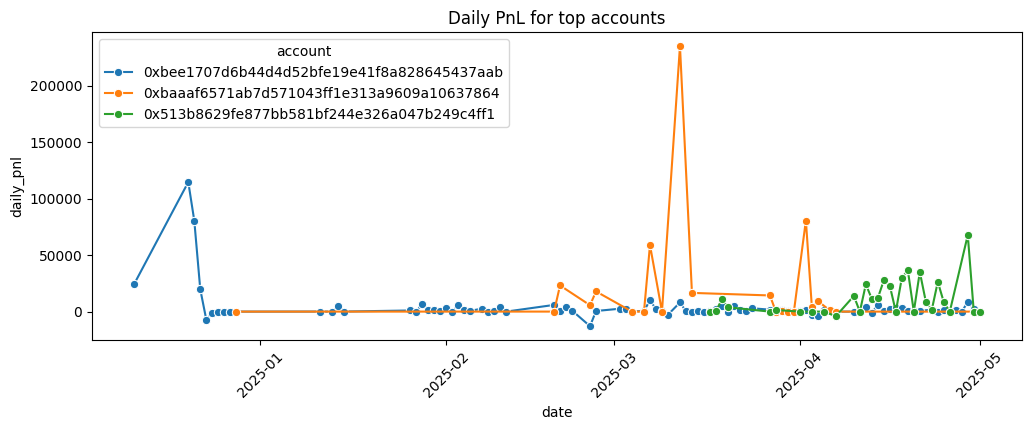

In [49]:
# pick top 3 accounts by total_pnl and plot daily pnl over time
top_accounts = acct_stats.sort_values('total_pnl', ascending=False).head(3)['account'].tolist()
daily = df_sentiment.groupby(['date','account']).agg(daily_pnl=('closedPnL','sum')).reset_index()
plot_df = daily[daily['account'].isin(top_accounts)]

plt.figure(figsize=(12,4))
sns.lineplot(data=plot_df, x='date', y='daily_pnl', hue='account', marker='o')
plt.title("Daily PnL for top accounts")
plt.xticks(rotation=45)
plt.show()